In [ ]:
import matplotlib.pyplot as plt
import random
import math
import sys
import time

In [ ]:
class KMeans:
    
    def __init__(
      self, n_clusters=8, init='mn_2sg_rng', n_init=10, max_iter=300):
        
        self.n_clusters = n_clusters
        self.init = init
        self.n_init = n_init
        self.max_iter = max_iter

        self.clr_arr = ['lime', 'orange', 'yellow', 'plum', 'teal']

    def __get_mins_and_maxs__(self, KNN_A):
        
        number_of_points = len(KNN_A)
        number_of_dimensions = len(KNN_A[0])

        mins = [1e10] * number_of_dimensions
        maxs = [-1e10] * number_of_dimensions

        for i in range(number_of_points):
            for j in range(number_of_dimensions):
                if KNN_A[i][j] < mins[j]:
                    mins[j] = KNN_A[i][j]
                if KNN_A[i][j] > maxs[j]:
                    maxs[j] = KNN_A[i][j]

        return mins, maxs

    def __get_random_point_from_point__(self, arr, half_range):
        
        number_of_dimensions = len(arr)

        pt = []
        for i in range(number_of_dimensions):
            var = random.uniform(-half_range[i], half_range[i])
            pt.append(arr[i]+var)

        return pt

    def __get_random_point_in_range__(self, mins, maxs):
        
        pt = []
        for i in range(len(mins)):
            pt.append(random.uniform(mins[i], maxs[i]))

        return pt

    def __get_distribution_parameters_of_pts__(self, KNN_A):
        
        num_pts = len(KNN_A)
        number_of_dimensions = len(KNN_A[0])

        means = [0] * number_of_dimensions
        stds = [0] * number_of_dimensions

        # Determine means for each dimension
        for arr in KNN_A:
            for i in range(number_of_dimensions):
                means[i] += arr[i]
        for i in range(number_of_dimensions):
            means[i] /= num_pts

        # Determine standard deviations for each dimension
        for arr in KNN_A:
            for i in range(number_of_dimensions):
                stds[i] += (means[i] - arr[i])**2
        for i in range(number_of_dimensions):
            stds[i] = (stds[i] / num_pts)**0.5

        return means, stds

    def __get_distance_between_two_points__(self, arr1, arr2):
        
        err_str = 'Error in "__get_distance_between_two_points__":\n'
        err_str += 'Point arrays do not have the same dimensions.'

        if len(arr1) != len(arr2):
            raise ArithmeticError(error_string)

        sq_dist = 0
        for i in range(len(arr1)):
            sq_dist += (arr1[i] - arr2[i])**2

        return sq_dist**0.5

    def __group_points_by_centroids__(self, grps, KNN_C, KNN_A):
        
        for pta in KNN_A:
            minD = 1e10
            for i in range(len(KNN_C)):
                ptc = KNN_C[i]
                dist = self.__get_distance_between_two_points__(
                    ptc, pta)
                if dist < minD:
                    closest_centroid = i
                    minD = dist

            grps[closest_centroid]['points'].append(pta)
            if grps[closest_centroid]['centroids'] == []:
                grps[closest_centroid]['centroids'] = \
                    KNN_C[closest_centroid]

        return grps

    def __determine_inertia__(self, grps):
        
        inertia = 0
        for i in range(len(grps)):
            for j in range(len(grps[i]['points'])):
                dist = self.__get_distance_between_two_points__(
                        grps[i]['centroids'],
                        grps[i]['points'][j])
                inertia += (dist) ** 2

        return inertia

    def __update_centroids__(self, grps, KNN_A):
        
        KNN_C_New = []
        total_number_of_clusters = len(grps)
        number_of_dimensions = len(KNN_A[0])
        mins, maxs = self.__get_mins_and_maxs__(KNN_A)

        for i in range(total_number_of_clusters):
            number_of_points_in_cluster = len(grps[i]['points'])
            if number_of_points_in_cluster == 0:
                # assign that centroid a new random location
                KNN_C_New.append(
                    self.__get_random_point_in_range__(mins, maxs))
                grps[i]['centroids'] = KNN_C_New[-1]
                continue  # then continue

            cnt_locs = [0] * number_of_dimensions

            for j in range(number_of_dimensions):
                for k in range(number_of_points_in_cluster):
                    cnt_locs[j] += grps[i]['points'][k][j]
                cnt_locs[j] /= number_of_points_in_cluster

            grps[i]['centroids'] = cnt_locs
            KNN_C_New.append(cnt_locs)

        return KNN_C_New, grps

    def __find_Arrays_delta__(self, KNN_C, KNN_C_New):
        
        dist_sum = 0
        for i in range(len(KNN_C)):
            dist_sum += self.__get_distance_between_two_points__(
                KNN_C[i], KNN_C_New[i])

        return dist_sum

    def __initial_disbursement_of_centroids__(
      self, KNN_A, n_clusters, method='mn_2sg_rng'):
        
        #  method='mean_std_spiral'
        means, stds = self.__get_distribution_parameters_of_pts__(
            KNN_A)

        two_sig = []
        for element in stds:
            two_sig.append(element*2.0)

        KNN_C = []

        if method == 'mn_2sg_rng':
            for i in range(n_clusters):
                KNN_C.append(
                    self.__get_random_point_from_point__(
                        means, two_sig))

            return KNN_C

        elif method == 'mean_std_spiral':
            num_dims = len(means)
            KNN_C.append(means.copy())
            cnt = 1
            radius = 1
            while True:
                for i in range(num_dims):
                    KNN_C.append(means.copy())
                    KNN_C[-1][i] += radius * stds[i]
                    cnt += 1
                    if cnt >= n_clusters:
                        return KNN_C

                for i in range(num_dims):
                    KNN_C.append(means.copy())
                    KNN_C[-1][i] -= radius * stds[i]
                    cnt += 1
                    if cnt >= n_clusters:
                        return KNN_C

                radius += 1

    def determine_k_clusters(self, KNN_A):
        
        min_inertia = 1e10
        for attempt in range(self.n_init):
            KNN_C = self.__initial_disbursement_of_centroids__(
                KNN_A, self.n_clusters)

            # Loop beginning
            cnt = 0
            while cnt < self.max_iter:
                grps = {}
                for i in range(self.n_clusters):
                    grps[i] = {'centroids': [], 'points': []}

                # Find groups by closest to centroid
                grps = self.__group_points_by_centroids__(grps, KNN_C, KNN_A)

                KNN_C_New, grps = self.__update_centroids__(grps, KNN_A)

                delta_As = self.__find_Arrays_delta__(KNN_C, KNN_C_New)

                if delta_As == 0:
                    break

                KNN_C = KNN_C_New

                cnt += 1

            #######
            current_inertia = self.__determine_inertia__(grps)
            if current_inertia < min_inertia:
                min_inertia = current_inertia
                grps_best = grps

        self.inertia_ = min_inertia

        return grps_best

    def plot_clusters(self, grps):
        
        Xc = []
        Yc = []

        for i in range(len(grps)):
            Xc.append(grps[i]['centroids'][0])
            Yc.append(grps[i]['centroids'][1])

        X = []
        Y = []
        for i in range(len(grps)):
            X.append([])
            Y.append([])
            for j in range(len(grps[i]['points'])):
                X[i].append(grps[i]['points'][j][0])
                Y[i].append(grps[i]['points'][j][1])

        for i in range(len(X)):
            plt.scatter(X[i], Y[i], c=self.clr_arr[i])

        plt.scatter(Xc, Yc, c='black')
        plt.xlabel('X Values')
        plt.ylabel('Y Values')
        plt.title('Fake Data Clusters')
        plt.show()

In [ ]:
class CreateFakeData(object):
    def __init__(self, seeds, half_range=2, points_per_cluster=10):
        self.seeds = seeds
        self.half_range = half_range
        self.points_per_cluster = points_per_cluster

    def __get_random_point_from_point__(self, arr, half_range):
        number_of_dimensions = len(arr)

        pt = []
        for i in range(number_of_dimensions):
            var = random.uniform(-half_range, half_range)
            pt.append(arr[i]+var)

        return pt

    def __get_random_point_in_range__(self, mins, maxs):
        pt = []
        for i in range(len(mins)):
            pt.append(random.uniform(mins[i], maxs[i]))

        return pt

    def create_fake_data(self):
        # Initialize fake data and centroids
        KNN_A = []

        for seed in self.seeds:
            for i in range(self.points_per_cluster):
                KNN_A.append(self.__get_random_point_from_point__(
                    seed, self.half_range))

        return KNN_A

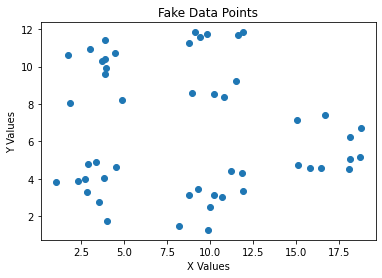

Inertia is 926.8192334852082.


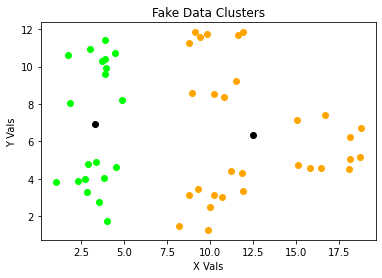

In [ ]:
def scatter_plot_points(pts):
    X = []
    Y = []

    for i in range(len(pts)):
        X.append(pts[i][0])
        Y.append(pts[i][1])

    plt.scatter(X, Y)
    plt.xlabel('X Values')
    plt.ylabel('Y Values')
    plt.title('Fake Data Points')
    plt.show()


# Setup Data
clr_arr = ['lime', 'olive', 'yellow', 'aqua', 'purple']
seeds = [[3, 10], [10, 3], [3, 3], [10, 10], [17, 6]]
half_range = 2


# Create Fake Data
fake_data = CreateFakeData(seeds)
KNN_A = fake_data.create_fake_data()
scatter_plot_points(KNN_A)


# Find the Clusters
kmeans = KMeans(n_clusters=2)
grps = kmeans.determine_k_clusters(KNN_A)
print('Inertia is {}.'.format(kmeans.inertia_))
kmeans.plot_clusters(grps)

Inertia is 563.6686926720585.


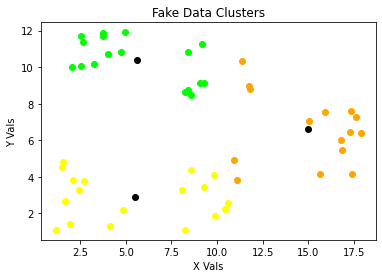

In [ ]:
# Find the Clusters
kmeans = KMeans(n_clusters=3)
grps = kmeans.determine_k_clusters(KNN_A)
print('Inertia is {}.'.format(kmeans.inertia_))
kmeans.plot_clusters(grps)

Inertia is 308.94164037223084.


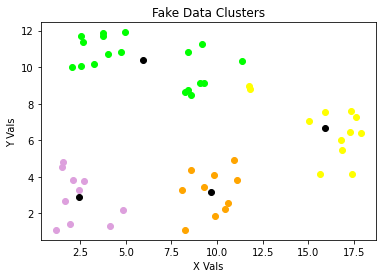

In [ ]:
# Find the Clusters
kmeans = KMeans(n_clusters=4)
grps = kmeans.determine_k_clusters(KNN_A)
print('Inertia is {}.'.format(kmeans.inertia_))
kmeans.plot_clusters(grps)

Inertia is 117.30643714919498.


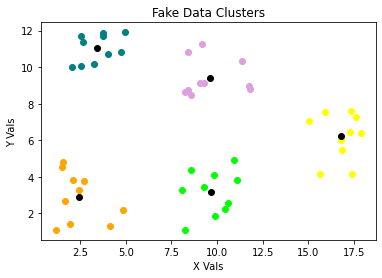

In [ ]:
# Find the Clusters
kmeans = KMeans(n_clusters=5)
grps = kmeans.determine_k_clusters(KNN_A)
print('Inertia is {}.'.format(kmeans.inertia_))
kmeans.plot_clusters(grps)

# KMeans Without Libraries

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

class kmeans:
    """Apply kmeans algorithm"""
    def __init__(self, num_clusters, max_iter=1000):
        """Initialize number of clusters"""
        
        self.num_clusters = num_clusters
        self.max_iter = max_iter
    
    def initalize_centroids(self, X):
        """Choosing k centroids randomly from data X"""
        
        idx = np.random.permutation(X.shape[0])
        centroids = X[idx[:self.num_clusters]]
        return centroids
        
    def compute_centroid(self, X, labels):
        """Modify centroids by finding mean of all k partitions"""
        
        centroids = np.zeros((self.num_clusters, X.shape[1]))
        for k in range(self.num_clusters):
            centroids[k] = np.mean(X[labels == k], axis=0)
            
        return centroids
    
    def compute_distance(self, X, centroids):
        """Computing L2 norm between datapoints and centroids"""

        distances = np.zeros((X.shape[0], self.num_clusters))
        
        for k in range(self.num_clusters):
            dist = np.linalg.norm(X - centroids[k], axis=1)
            distances[:,k] = np.square(dist)
            
        return distances
    
    def find_closest_cluster(self, distance):
        return np.argmin(distance, axis=1)
    
    def fit(self, X):
        self.centroids = self.initalize_centroids(X)
        
        for i in range(self.max_iter):
            old_centroids = self.centroids
            distance = self.compute_distance(X, old_centroids)
            self.labels = self.find_closest_cluster(distance)
            self.centroids = self.compute_centroid(X, self.labels)
            
            if np.all(old_centroids == self.centroids):
                break
        
    def compute_sumstar(self, distances):
        """Computing sum total of all distances"""
        pass

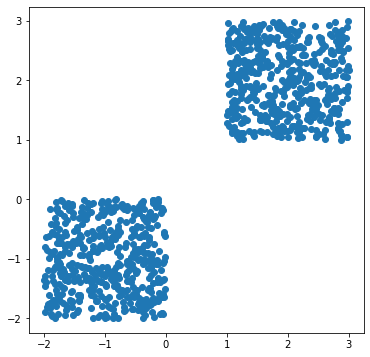

In [ ]:
# creating an artificial test case

np.random.RandomState(1234)
data = -2 * np.random.rand(1000, 2) 
data[500:] = 1 + 2 * np.random.rand(500,2)

# plotting the data 

plt.figure(figsize=(6,6))
plt.scatter(data[:,0], data[:, 1])
plt.show()

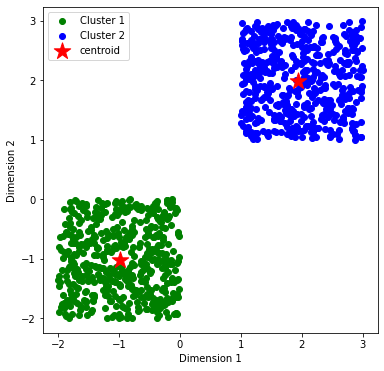

In [ ]:
# Applying k-means on the data

kmeansmodel = kmeans(num_clusters=2, max_iter=100)
kmeansmodel.fit(data)
centroids = kmeansmodel.centroids

centroids[0]

# plotting the clustered data with the centoids

plt.figure(figsize=(6,6))
plt.scatter(data[kmeansmodel.labels == 0, 0], data[kmeansmodel.labels == 0, 1], c = 'green', label = 'Cluster 1')
plt.scatter(data[kmeansmodel.labels == 1, 0], data[kmeansmodel.labels == 1, 1], c = 'blue', label = 'Cluster 2')
plt.scatter(centroids[:, 0], centroids[:, 1], marker='*', c = 'red', s = 300, label = 'centroid')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.legend()
plt.show()

# KMeans With Libraries

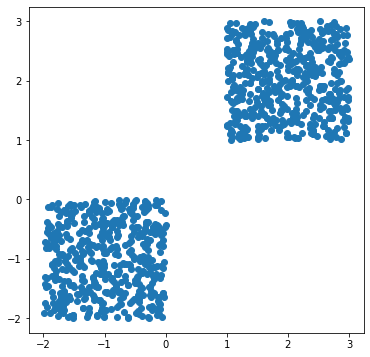

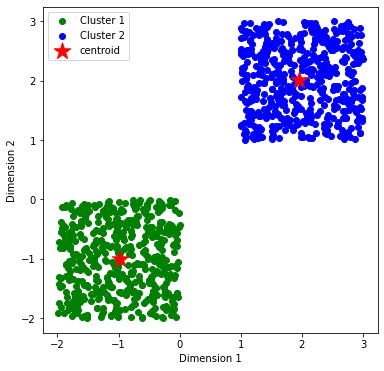

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# creating an artificial test case

np.random.RandomState(1234)
data = -2 * np.random.rand(1000, 2) 
data[500:] = 1 + 2 * np.random.rand(500,2)

# plotting the data 

plt.figure(figsize=(6,6))
plt.scatter(data[:,0], data[:, 1])
plt.show()

kmeansmodel = KMeans(n_clusters=2)
kmeansmodel.fit(data)

# plotting the clustered data with the centoids

plt.figure(figsize=(6,6))
plt.scatter(data[kmeansmodel.labels_ == 0, 0], data[kmeansmodel.labels_ == 0, 1], c = 'green', label = 'Cluster 1')
plt.scatter(data[kmeansmodel.labels_ == 1, 0], data[kmeansmodel.labels_ == 1, 1], c = 'blue', label = 'Cluster 2')
plt.scatter(kmeansmodel.cluster_centers_[:, 0], kmeansmodel.cluster_centers_[:, 1], marker='*', c = 'red', s = 300, label = 'centroid')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.legend()
plt.show()